This project uses articles from TechCrunch from 2010 to 2016 to conduct Natural Languages Processing analysis.

### Import the Packages and Data

In [1]:
import pandas as pd
import numpy as np
import random
import re
import nltk
import pickle
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import requests

%matplotlib inline

In [2]:
pd.options.display.max_columns = 100

### Import the data

In [3]:
raw = pd.read_csv('techcrunch_posts.csv')

In [4]:
# Drop the articles without contents

df = raw[pd.notnull(raw['content'])]

In [5]:
# Fill null values

df[['category']].fillna('none', inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39061 entries, 0 to 39114
Data columns (total 11 columns):
authors     38761 non-null object
category    38339 non-null object
content     39061 non-null object
date        39061 non-null object
id          39061 non-null int64
img_src     39061 non-null object
section     39061 non-null object
tags        34097 non-null object
title       39061 non-null object
topics      5590 non-null object
url         39061 non-null object
dtypes: int64(1), object(10)
memory usage: 3.6+ MB


In [7]:
df['category'].describe()

count     38339
unique       55
top        Apps
freq       9383
Name: category, dtype: object

### Exploratory Data Analysis

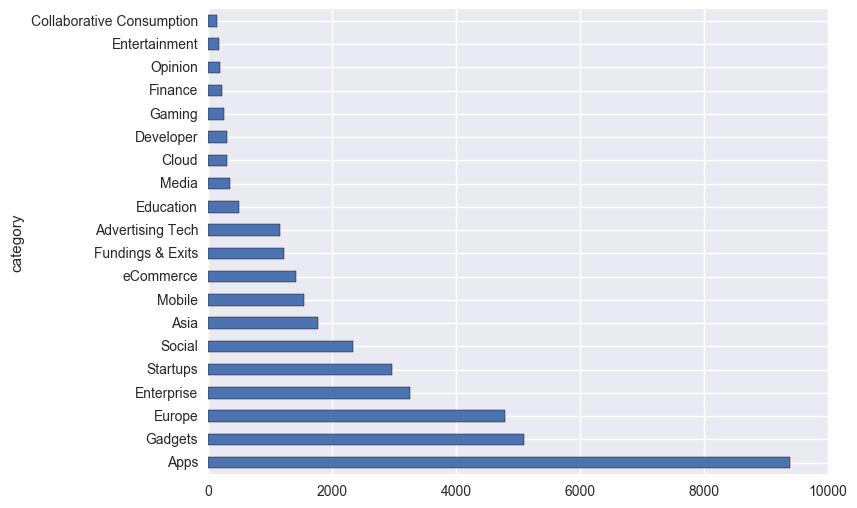

In [8]:
# Plot the categories

categories = df.groupby('category')['id'].count()
categories = categories.sort_values(ascending = False)[:20]

categories.plot(kind = 'barh', figsize=(8, 6))

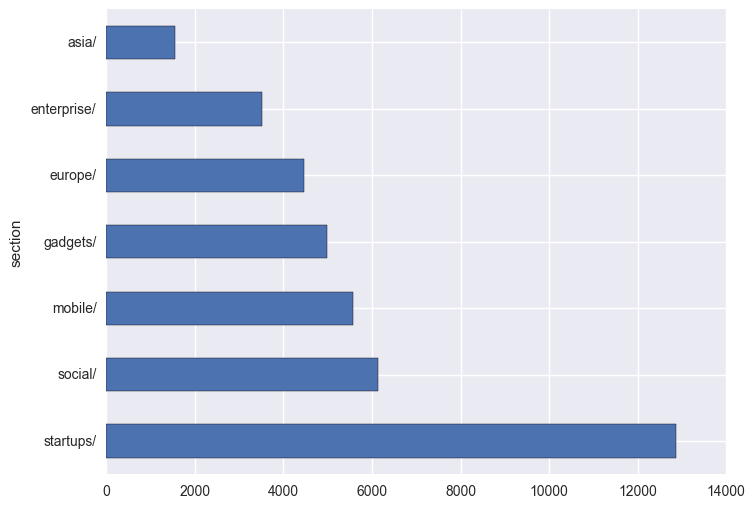

In [9]:
# Plot the sections

sections = df.groupby('section')['id'].count()
sections = sections.sort_values(ascending = False)[:20]

sections.plot(kind = 'barh', figsize=(8, 6))

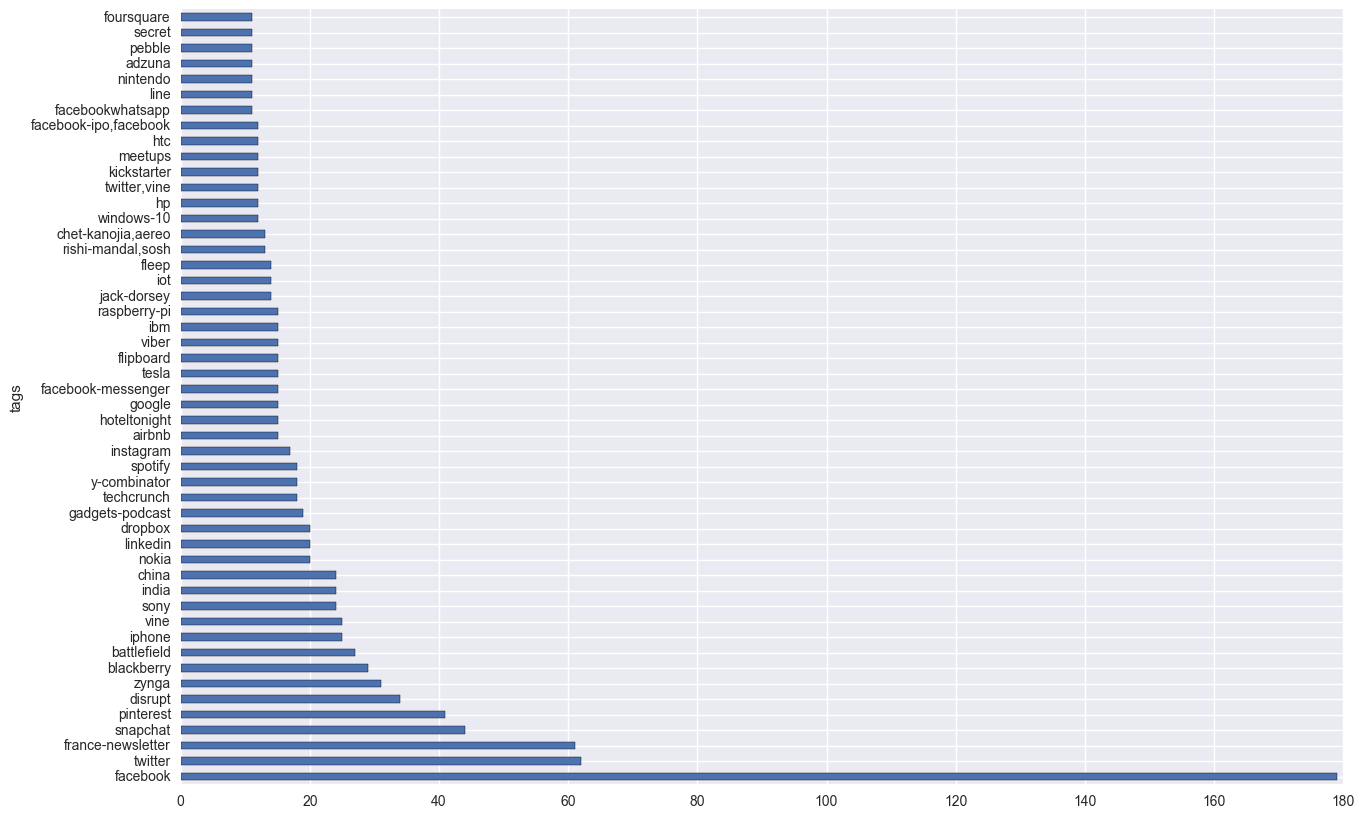

In [10]:
# Plot the tags

tags = df.groupby('tags')['id'].count()
tags = tags.sort_values(ascending = False)[:50]

tags.plot(kind = 'barh', figsize=(15, 10))

### Document Processing

In [11]:
# Create a list of tags with more than 10 documents

list_of_tags = []

for item in dict(tags[tags >= 10]).keys():
    list_of_tags.append(item)

In [12]:
len(list_of_tags)

50

There are 50 tags (aka topics) with more than 10 documents, such as facebook, twitter, techcruch, etc.

In [13]:
# Create a dataframe for only documents with top tags

def doc_with_tags(data, tags):
    dataframe = pd.DataFrame()
    for tag in tags:
        df_tag = df[df['tags'] == tag].sample(10)
        dataframe = dataframe.append(df_tag)
    return dataframe

In [14]:
df_tags = doc_with_tags(df, list_of_tags)

In [16]:
df_tags.head()

,authors,category,content,date,id,img_src,section,tags,title,topics,url
6857,Alex Wilhelm,Enterprise,"Microsoft’s Windows 10 has around 450,000 user...",2014-12-17,1095955,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Windows 10 Hits 1.5M Testers, With 450K Using ...",NaN,https://techcrunch.com/2014/12/17/windows-10-h...
7088,Alex Wilhelm,Enterprise,If you were disappointed when the Windows 10 c...,2014-12-02,1089505,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Windows 10 Build 9888 Leaks, Install At Your O...",NaN,https://techcrunch.com/2014/12/02/windows-10-b...
7641,Alex Wilhelm,Enterprise,Microsoft announced this morning that it cross...,2014-10-13,1069019,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,Windows 10 Attracts 1M Testers In Two Weeks,microsoft,https://techcrunch.com/2014/10/13/windows-10-a...
6862,Alex Wilhelm,Enterprise,Microsoft recently announced that it would not...,2014-12-15,1094744,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,Here’s What You Need To Know About The Latest ...,NaN,https://techcrunch.com/2014/12/15/heres-what-y...
6973,Alex Wilhelm,Developer,"Microsoft’s Gabriel Aul, one of the most promi...",2014-12-09,1092596,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,If You’re Running Windows 10 You May Have To R...,NaN,https://techcrunch.com/2014/12/09/if-youre-run...


In [21]:
df_tags[df_tags['tags'] == 'iphone'].iloc[0]['url']

'https://techcrunch.com/2015/03/24/apple-patents-a-light-splitting-iphone-camera-sensor-system/'

In [22]:
pd.to_pickle(df_tags, 'df_tag.pkl')

In [23]:
pd.read_pickle('df_tag.pkl')

,authors,category,content,date,id,img_src,section,tags,title,topics,url
6857,Alex Wilhelm,Enterprise,"Microsoft’s Windows 10 has around 450,000 user...",2014-12-17,1095955,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Windows 10 Hits 1.5M Testers, With 450K Using ...",NaN,https://techcrunch.com/2014/12/17/windows-10-h...
7088,Alex Wilhelm,Enterprise,If you were disappointed when the Windows 10 c...,2014-12-02,1089505,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Windows 10 Build 9888 Leaks, Install At Your O...",NaN,https://techcrunch.com/2014/12/02/windows-10-b...
7641,Alex Wilhelm,Enterprise,Microsoft announced this morning that it cross...,2014-10-13,1069019,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,Windows 10 Attracts 1M Testers In Two Weeks,microsoft,https://techcrunch.com/2014/10/13/windows-10-a...
6862,Alex Wilhelm,Enterprise,Microsoft recently announced that it would not...,2014-12-15,1094744,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,Here’s What You Need To Know About The Latest ...,NaN,https://techcrunch.com/2014/12/15/heres-what-y...
6973,Alex Wilhelm,Developer,"Microsoft’s Gabriel Aul, one of the most promi...",2014-12-09,1092596,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,If You’re Running Windows 10 You May Have To R...,NaN,https://techcrunch.com/2014/12/09/if-youre-run...
7766,Alex Wilhelm,Enterprise,"1, 2, 3, 95, 98, 2000, ME, XP, Vista, 7, 8, 8....",2014-10-04,1065907,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,A Few Thoughts On Windows 10,NaN,https://techcrunch.com/2014/10/04/a-few-though...
6623,Alex Wilhelm,Enterprise,Update: Microsoft promised a new build of Wind...,2015-01-21,1108352,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,Microsoft To Provide Free Upgrades To Windows 10,microsoft,https://techcrunch.com/2015/01/21/microsoft-to...
7099,Alex Wilhelm,Enterprise,Microsoft previously announced that Windows 10...,2014-11-20,1086132,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Microsoft Promises Managed, Web-Based App Stor...",NaN,https://techcrunch.com/2014/11/20/microsoft-pr...
6513,Alex Wilhelm,Enterprise,I presume by now that if you are a Windows kid...,2015-01-25,1110192,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,"Here’s How To Turn On Windows 10’s New, Hidden...",NaN,https://techcrunch.com/2015/01/25/heres-how-to...
6624,Alex Wilhelm,Enterprise,"Today at its Windows 10 event, Microsoft annou...",2015-01-21,1108326,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,windows-10,1.7 Million People Are Testing Windows 10,microsoft,https://techcrunch.com/2015/01/21/1-7-million-...


In [21]:
for tag in list_of_tags:
    d_url = dict()
    if tag not in d_url.keys():
        print (d_url.keys())
        print (tag)
        d_url[str(tag)] = (df[df['tags'] == tag]['url'].iloc[0])
        
        print (d_url[tag])
    else:
        continue

[]
battlefield
https://techcrunch.com/2016/10/02/hamwells-raises-e1-2-million-for-the-connected-e-shower-of-the-future/
[]
google
https://techcrunch.com/2013/10/22/google-flexycore/
[]
htc
https://techcrunch.com/2015/01/06/htc-q4-2014/
[]
instagram
https://techcrunch.com/2014/03/03/is-instagram-down/
[]
tesla
https://techcrunch.com/2016/09/07/missouri-court-rules-against-tesla-selling-at-its-own-dealerships-in-the-state/
[]
windows-10
https://techcrunch.com/2015/01/25/heres-how-to-turn-on-windows-10s-new-hidden-calendar-and-clock/
[]
twitter
https://techcrunch.com/2014/07/29/twitter-q2-user-growth/
[]
twitter,vine
https://techcrunch.com/2014/07/01/vine-update-introduces-loop-counts-so-you-know-how-great-you-are/
[]
india
https://techcrunch.com/2015/10/08/google-releases-experimental-public-transport-app-for-delhi-india/
[]
snapchat
https://techcrunch.com/2015/02/18/snapchat-now-lets-you-record-and-play-music-at-the-same-time/
[]
sony
https://techcrunch.com/2016/09/07/the-ps4-slim-is-co

In [22]:
d_url

{'fleep': 'https://techcrunch.com/2014/08/27/fleep-freemium/'}

In [36]:
print (df.groupby('tags')['tags'])

In [16]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 21265 to 14598
Data columns (total 11 columns):
authors     496 non-null object
category    494 non-null object
content     500 non-null object
date        500 non-null object
id          500 non-null int64
img_src     500 non-null object
section     500 non-null object
tags        500 non-null object
title       500 non-null object
topics      85 non-null object
url         500 non-null object
dtypes: int64(1), object(10)
memory usage: 46.9+ KB


I will use this dataframe 'df_tags' for the rest of the analysis.

#### WordCloud Showing the Tags

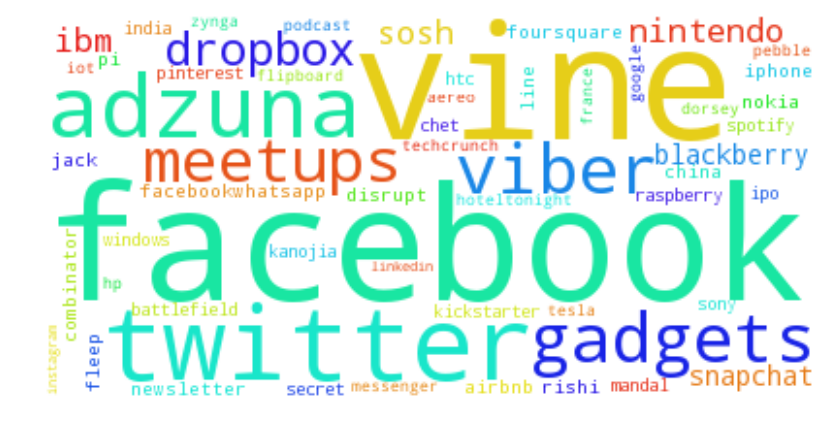

In [17]:
# Word Cloud for displaying tags (without word size weights)

list_of_tags_combined = ' '.join([str(t) for t in df_tags['tags']])
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white').generate(cloud_text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# wordcloud.to_file('wordcloud.png')

### Process the Article Content

##### Removing punctuation, convert words to lower case, remove stop words and stemming.

In [18]:
def process_content(data):
    
    # Keep only the words, remove punctuations
    formatted_content = re.sub("[^a-zA-Z]", " ", data)
    
    # Convert all words to lower case and split into a list
    words = formatted_content.lower().split()
    
    # List of stop words
    stop = stopwords.words('english')
    
    # Produce a list of clean words that does not appear in stop words
    clean_words = [w for w in words if w not in stop]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    stem_clean_words = [stemmer.stem(w) for w in clean_words if w not in stop]

    return " ".join(stem_clean_words)

In [19]:
# Create a list of clean contents for df_tags

def concat_tag_content(data, tag_list):
    total_list = []
    n = 0
    for tag in tag_list:
        print (str(n) + ' ' + tag)
        tags_clean_content = []
        sub_df = data[data['tags'] == tag]
        sub_list = []
        for article in sub_df['content']:
            sub_list.append(process_content(article))
        tags_clean_content.append(sub_list)
        words = [w for sublist in tags_clean_content for w in sublist]
        total_list.append(" ".join(words))
        n += 1
    return total_list

In [20]:
concat = concat_tag_content(df_tags, list_of_tags)

0 adzuna
1 viber
2 y-combinator
3 meetups
4 windows-10
5 dropbox
6 nintendo
7 ibm
8 blackberry
9 facebookwhatsapp
10 airbnb
11 nokia
12 france-newsletter
13 china
14 iphone
15 fleep
16 vine
17 raspberry-pi
18 disrupt
19 rishi-mandal,sosh
20 jack-dorsey
21 line
22 sony
23 battlefield
24 snapchat
25 spotify
26 kickstarter
27 htc
28 secret
29 india
30 pinterest
31 foursquare
32 hoteltonight
33 twitter,vine
34 hp
35 facebook
36 google
37 chet-kanojia,aereo
38 pebble
39 gadgets-podcast
40 zynga
41 techcrunch
42 twitter
43 flipboard
44 tesla
45 facebook-ipo,facebook
46 facebook-messenger
47 iot
48 instagram
49 linkedin


In [21]:
concat

['adzuna uk startup oper call next gener job search engin take ware germani first time london base compani expand intern also put decent number today monthli visitor uk properti million half million monthli visitor report last juli new site adzuna de featur job search function uk offer index thousand german job vacanc found classifi ad job board around web mine data search engin provid free access labour market trend track salari particular vocat region well build social layer top latter enabl offer featur call adzuna connect wherebi user sign adzuna via facebook linkedin leverag social graph help get particular compani job vacanc tri fill compani say live job vacanc germani repres billion total earn opportun somewhat encourag news least countri million unemploy certainli encourag adzuna term pent demand servic end adzuna co founder andrew hunter say job seeker germani current underserv tool avail compani aim address interestingli also tell adzuna intend reach german govern offer build

In [22]:
len(concat)

50

In [23]:
# Store the list of concatenated articles for 50 tag words in variable 'contents'

contents = concat

### TD-IDF Matrix

In [30]:
# TF-IDF Matrix for top 100 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
x_tfidf = tfidf.fit_transform(contents)

In [31]:
print('Matrix')
x_back_tfidf = x_tfidf.toarray()
print(x_back_tfidf)

Matrix
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.00785073  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [32]:
TFIDF_df = pd.DataFrame(x_back_tfidf, columns=tfidf.get_feature_names())
TFIDF_df.index = list_of_tags
TFIDF_df = TFIDF_df.round(2)
TFIDF_df.head(10)

,aaron,aarp,abandon,abbyy,abid,abil,abl,aboard,abort,abosch,abound,abroad,absolut,absorb,absorpt,abstract,absurd,abund,abus,aca,academ,academi,academia,acapulco,accel,acceler,accentu,accentur,accept,access,accessori,accid,accident,accolad,accommod,accomplish,accord,accordingli,account,accoutr,accredit,accret,accumul,accur,accuraci,accus,ace,achiev,acknowledg,acorn,...,yesteryear,yield,yik,yikyak,yin,yipit,yoko,yokohama,yolo,yon,york,yorker,yoshi,yoshioka,yougov,young,younger,youngster,yourkarma,yourvoic,youth,youtub,yoy,yplan,yummi,yuri,yurt,yve,zachari,zealand,zeitgeisti,zelda,zemanta,zenefit,zeng,zeppelin,zero,zigbe,zingbox,zip,zipcar,zombi,zone,zoom,zoopla,zuber,zuck,zuckbook,zuckerberg,zynga
adzuna,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.01,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.08,0.0,0.0,0.0,0.0,0.0
viber,0.00,0.0,0.00,0.0,0.0,0.02,0.02,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
y-combinator,0.00,0.0,0.00,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.03,0.0,0.00,0.00,0.01,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.02,0.01,0.0,...,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.00,0.0,0.00,0.07,0.00,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
meetups,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.02,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
windows-10,0.00,0.0,0.00,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.0,0.02,0.00,0.0,0.0,0.0,0.04,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0
dropbox,0.00,0.0,0.00,0.0,0.0,0.01,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.00,0.0,0.00,0.01,0.03,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
nintendo,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
ibm,0.01,0.0,0.00,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0.00,0.00,0.02,0.0,0.00,0.00,0.

### Clustering 

#### PCA

In [62]:
# PCA using SVD - 5 components

pca_reducer_5 = PCA(n_components = 5, random_state= 4444)
pca_reduced_X_5 = pca_reducer_5.fit_transform(x_back_tfidf)

sum(pca_reducer_5.explained_variance_ratio_)

0.3609356722318704

In [63]:
# PCA using SVD - 20 components

pca_reducer_20 = PCA(n_components = 20, random_state= 4444)
pca_reduced_X_20 = pca_reducer_20.fit_transform(x_back_tfidf)

sum(pca_reducer_20.explained_variance_ratio_)

0.82063194878283663

#### Demonstration of Clustering - Kmeans

In [64]:
# Plot the Cluster vs Silhouetee

def plot_clusters(components, num_clusters, tfidf):
    plot_pca_reducer = PCA(n_components = components, random_state= 4444)
    plot_pca_reduced_X = plot_pca_reducer.fit_transform(tfidf)
    sil_list = []
    for n in list(range(2, num_clusters + 1)):
        num_clusters = n
        km = KMeans(n_clusters=num_clusters, random_state = 4444)
        km.fit(plot_pca_reduced_X)
        clusters = km.labels_.tolist()
        sil_list.append(silhouette_score(plot_pca_reduced_X, clusters))
    plt.plot(list(range(2, num_clusters + 1)), sil_list)
    plt.title('Silhouette Score vs Num of Clusters with ' + str(components) + ' Components')

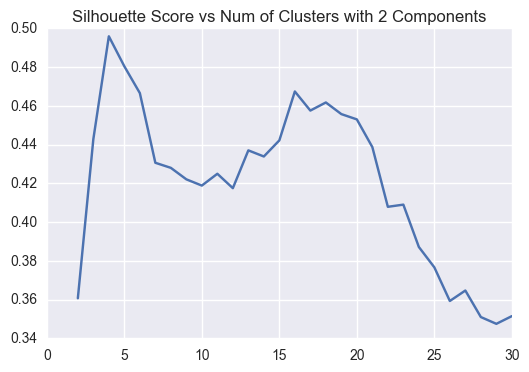

In [65]:
plot_clusters(2, 30, x_back_tfidf)

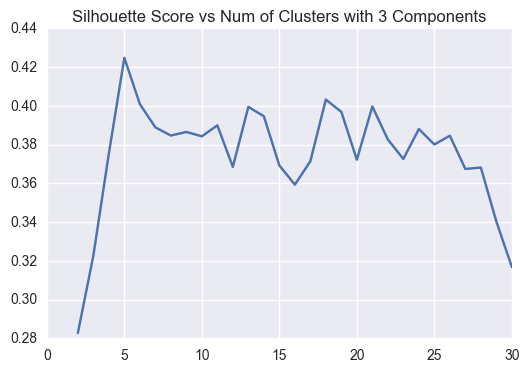

In [66]:
plot_clusters(3, 30, x_back_tfidf)

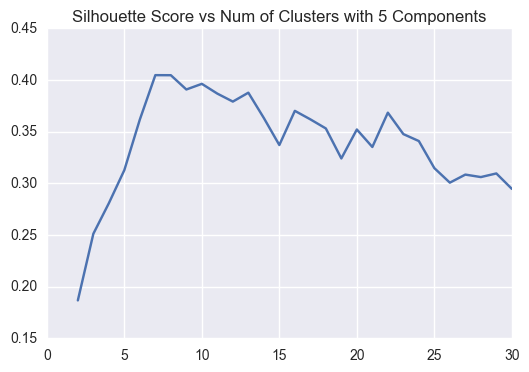

In [67]:
plot_clusters(5, 30, x_back_tfidf)

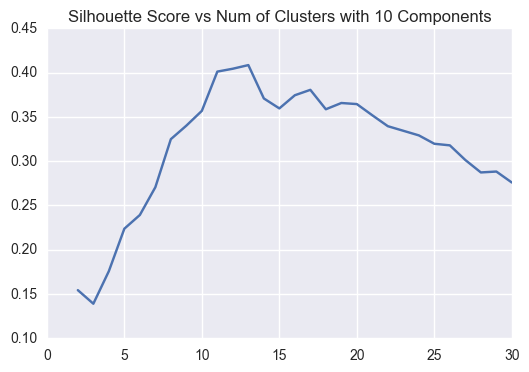

In [68]:
plot_clusters(10, 30, x_back_tfidf)

As you can see, the result from clustering isn't ideal - the silhouette score can't get higher than 0.5. Let's take a look at the data in 3D and see if we can detect any pattern.

### Visualize the Data

In [69]:
# PCA using SVD - 3 components

pca_reducer_3 = PCA(n_components = 3, random_state= 4444)
pca_reduced_X_3 = pca_reducer_3.fit_transform(x_back_tfidf)

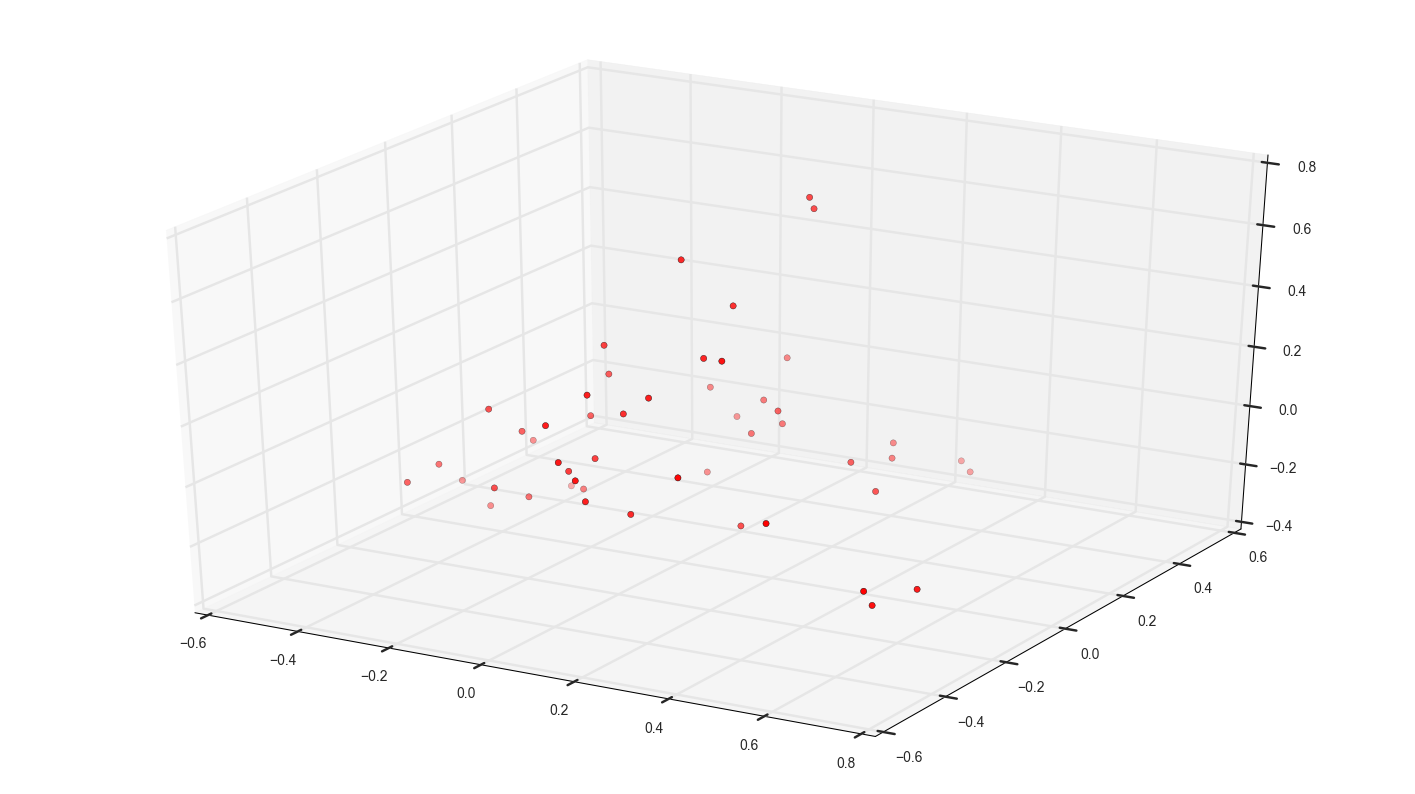

In [136]:
fig = plt.figure(figsize=(18, 10)) 
ax = fig.add_subplot(111, projection='3d')

reduced_df = pd.DataFrame(pca_reduced_X_3)

ax.scatter(reduced_df[0], reduced_df[1], reduced_df[2], c='r')

plt.show()

### Distance Based Recommendation

In [84]:
# Pairwise Euclidean Distance Matrix 

dist_df = pd.DataFrame(pairwise_distances(reduced_df, metric = 'euclidean'), columns=list_of_tags)
dist_df.index = list_of_tags
dist_df = dist_df.round(2)
dist_df.head(10)

,google,viber,snapchat,instagram,facebook,battlefield,windows-10,secret,vine,flipboard,facebook-messenger,dropbox,pebble,airbnb,hoteltonight,y-combinator,twitter,sony,india,"facebook-ipo,facebook",blackberry,adzuna,linkedin,facebookwhatsapp,meetups,zynga,nokia,fleep,"rishi-mandal,sosh",france-newsletter,pinterest,"twitter,vine",foursquare,jack-dorsey,htc,techcrunch,gadgets-podcast,hp,disrupt,iot,iphone,kickstarter,ibm,tesla,nintendo,line,spotify,raspberry-pi,"chet-kanojia,aereo",china
google,0.00,0.38,0.50,0.32,0.70,0.54,0.13,0.21,0.50,0.43,0.74,0.51,0.53,0.34,0.45,0.35,0.30,0.52,0.52,0.73,0.65,0.41,0.52,0.57,0.60,0.35,0.33,0.39,0.35,0.40,0.54,0.50,0.52,0.30,0.65,0.63,0.25,0.69,0.39,0.47,0.60,0.14,0.55,0.29,0.45,0.46,0.12,0.26,0.33,0.69
viber,0.38,0.00,0.33,0.52,0.75,0.59,0.37,0.47,0.81,0.06,0.72,0.21,0.44,0.21,0.24,0.37,0.61,0.31,0.27,0.73,0.41,0.42,0.20,0.49,0.81,0.34,0.44,0.26,0.16,0.33,0.23,0.81,0.19,0.63,0.48,0.83,0.56,0.54,0.50,0.25,0.56,0.44,0.22,0.50,0.34,0.21,0.43,0.46,0.29,0.40
snapchat,0.50,0.33,0.00,0.49,0.55,0.65,0.55,0.51,0.90,0.34,0.48,0.31,0.76,0.52,0.33,0.37,0.69,0.61,0.57,0.51,0.73,0.34,0.21,0.21,0.87,0.38,0.67,0.26,0.29,0.51,0.19,0.89,0.24,0.73,0.79,0.89,0.73,0.86,0.54,0.57,0.87,0.62,0.51,0.74,0.63,0.22,0.59,0.70,0.55,0.70
instagram,0.32,0.52,0.49,0.00,0.42,0.79,0.35,0.12,0.45,0.56,0.50,0.66,0.75,0.59,0.63,0.54,0.25,0.66,0.76,0.47,0.84,0.56,0.56,0.44,0.84,0.26,0.46,0.55,0.53,0.67,0.60,0.42,0.62,0.31,0.79,0.87,0.52,0.87,0.63,0.69,0.76,0.41,0.69,0.51,0.60,0.47,0.34,0.54,0.62,0.86
facebook,0.70,0.75,0.55,0.42,0.00,1.07,0.74,0.53,0.80,0.76,0.15,0.83,1.07,0.90,0.84,0.79,0.65,0.92,1.02,0.10,1.10,0.76,0.66,0.35,1.17,0.48,0.82,0.75,0.77,0.96,0.70,0.76,0.75,0.72,1.06,1.20,0.93,1.16,0.91,0.97,1.08,0.82,0.90,0.91,0.89,0.58,0.75,0.94,0.94,1.08
battlefield,0.54,0.59,0.65,0.79,1.07,0.00,0.63,0.71,0.98,0.64,1.05,0.52,0.77,0.54,0.42,0.29,0.81,0.81,0.58,1.08,0.82,0.33,0.71,0.81,0.31,0.80,0.79,0.41,0.45,0.30,0.66,0.99,0.61,0.80,0.94,0.31,0.56,0.93,0.17,0.63,0.94,0.58,0.75,0.70,0.80,0.73,0.63,0.59,0.42,0.85
windows-10,0.13,0.37,0.55,0.35,0.74,0.63,0.00,0.24,0.46,0.42,0.78,0.54,0.44,0.31,0.50,0.45,0.28,0.44,0.50,0.77,0.57,0.52,0.53,0.63,0.69,0.33,0.20,0.46,0.40,0.44,0.57,0.47,0.54,0.28,0.54,0.72,0.25,0.59,0.49,0.42,0.48,0.11,0.50,0.19,0.35,0.47,0.06,0.20,0.33,0.63
secret,0.21,0.47,0.51,0.12,0.53,0.71,0.24,0.00,0.40,0.52,0.60,0.63,0.66,0.50,0.58,0.49,0.18,0.60,0.68,0.58,0.77,0.52,0.55,0.50,0.75,0.27,0.38,0.51,0.48,0.59,0.59,0.39,0.60,0.23,0.73,0.79,0.40,0.80,0.55,0.61,0.68,0.30,0.64,0.40,0.53,0.47,0.22,0.43,0.52,0.81
vine,0.50,0.81,0.90,0.45,0.80,0.98,0.46,0.40,0.00,0.86,0.91,0.99,0.80,0.76,0.94,0.83,0.22,0.82,0.95,0.87,0.98,0.88,0.92,0.88,0.90,0.60,0.48,0.88,0.84,0.87,0.97,0.05,0.97,0.19,0.87,0.94,0.48,0.92,0.84,0.86,0.73,0.46,0.93,0.45,0.71,0.84,0.41,0.54,0.78,1.04
flipboard,0.43,0.06,0.34,0.56,0.76,0.64,0.42,0.52,0.86,0.00,0.73,0.21,0.45,0.25,0.26,0.41,0.65,0.29,0.27,0.74,0.39,0.46,0.18,0.50,0.86,0.36,0.47,0.30,0.20,0.37,0.21,0.86,0.17,0.68,0.47,0.88,0.61,0.53,0.55,0.25,0.57,0.49,0.18,0.55,0.34,0.20,0.48,0.50,0.33,0.37


In [85]:
# Recommendation Function

def dist_rec(tag):
    dist_df = pd.read_pickle('dist_df.pkl')
    d = dict(dist_df[tag])
    sorted_dist = sorted(d.items(), key=lambda x: x[1])
    return sorted_dist[1], ' ', sorted_dist[2], sorted_dist[3]

In [86]:
# Example recommendation

dist_rec('htc')

(('blackberry', 0.059999999999999998),
 ('nokia', 0.070000000000000007),
 ('iphone', 0.14999999999999999))

In [87]:
# Example recommendation

dist_rec('facebook')

(('facebook-messenger', 0.02),
 ('facebook-ipo,facebook', 0.029999999999999999),
 ('facebookwhatsapp', 0.23999999999999999))

In [88]:
# Example recommendation

dist_rec('twitter')

# Jack Dorsey is the co-founder of Twittera

(('jack-dorsey', 0.029999999999999999),
 ('vine', 0.14000000000000001),
 ('twitter,vine', 0.14999999999999999))

In [89]:
# Example recommendation

dist_rec('dropbox')

# rishi-mandal is the co-founder of sosh, which was acquired by postmate

(('spotify', 0.040000000000000001),
 ('rishi-mandal,sosh', 0.080000000000000002),
 ('foursquare', 0.080000000000000002))

In [90]:
# Example recommendation

dist_rec('tesla')

(('windows-10', 0.13),
 ('flipboard', 0.17999999999999999),
 ('raspberry-pi', 0.20000000000000001))

In [ ]:
dist_rec('tesla')

### Sentiment Analysis with Tags

In [92]:
# Sentiment of articles

def article_sentiment(data):
    d = OrderedDict()
    n = 0
    for item in data:
        name = list_of_tags[n]
        d[name] = TextBlob(item).sentiment[0]
        n += 1
    return d

In [93]:
df_sentiments = article_sentiment(contents)

In [94]:
df_sentiment_sorted = sorted(df_sentiments.items(), key=lambda x: x[1])

In [95]:
# Display the sentiment with each tag in ascending order

df_sentiment_sorted

[('zynga', -0.07949968264817887),
 ('secret', -0.07626923479746028),
 ('line', -0.04438807250688441),
 ('nintendo', -0.03207387193583515),
 ('india', 0.023875037176563915),
 ('nokia', 0.026498685363716027),
 ('blackberry', 0.028194288790735496),
 ('kickstarter', 0.029081526271893234),
 ('iot', 0.03935634087028505),
 ('jack-dorsey', 0.040619145449653914),
 ('viber', 0.042781495715169204),
 ('snapchat', 0.052561355855473474),
 ('facebook-ipo,facebook', 0.05294824234407565),
 ('iphone', 0.05364246702909496),
 ('ibm', 0.05788360881542701),
 ('china', 0.06420558193879089),
 ('spotify', 0.06457814534361764),
 ('adzuna', 0.06610069854388033),
 ('instagram', 0.06823428459350794),
 ('google', 0.07024976205827266),
 ('facebook', 0.0718479537810393),
 ('hoteltonight', 0.07552876792238493),
 ('twitter,vine', 0.0764294459749005),
 ('foursquare', 0.07649710258096336),
 ('sony', 0.07698126784562953),
 ('pinterest', 0.07737920544022912),
 ('raspberry-pi', 0.07947926634768739),
 ('france-newsletter', 0

In [106]:
df_sentiment_neg = df_sentiment_sorted[0:4]
df_sentiment_pos = df_sentiment_sorted[4:]

In [108]:
df_sentiment_pos

[('india', 0.023875037176563915),
 ('nokia', 0.026498685363716027),
 ('blackberry', 0.028194288790735496),
 ('kickstarter', 0.029081526271893234),
 ('iot', 0.03935634087028505),
 ('jack-dorsey', 0.040619145449653914),
 ('viber', 0.042781495715169204),
 ('snapchat', 0.052561355855473474),
 ('facebook-ipo,facebook', 0.05294824234407565),
 ('iphone', 0.05364246702909496),
 ('ibm', 0.05788360881542701),
 ('china', 0.06420558193879089),
 ('spotify', 0.06457814534361764),
 ('adzuna', 0.06610069854388033),
 ('instagram', 0.06823428459350794),
 ('google', 0.07024976205827266),
 ('facebook', 0.0718479537810393),
 ('hoteltonight', 0.07552876792238493),
 ('twitter,vine', 0.0764294459749005),
 ('foursquare', 0.07649710258096336),
 ('sony', 0.07698126784562953),
 ('pinterest', 0.07737920544022912),
 ('raspberry-pi', 0.07947926634768739),
 ('france-newsletter', 0.0795099476201838),
 ('twitter', 0.07962902482133252),
 ('htc', 0.08044925444925446),
 ('dropbox', 0.08137980241222566),
 ('battlefield', 0

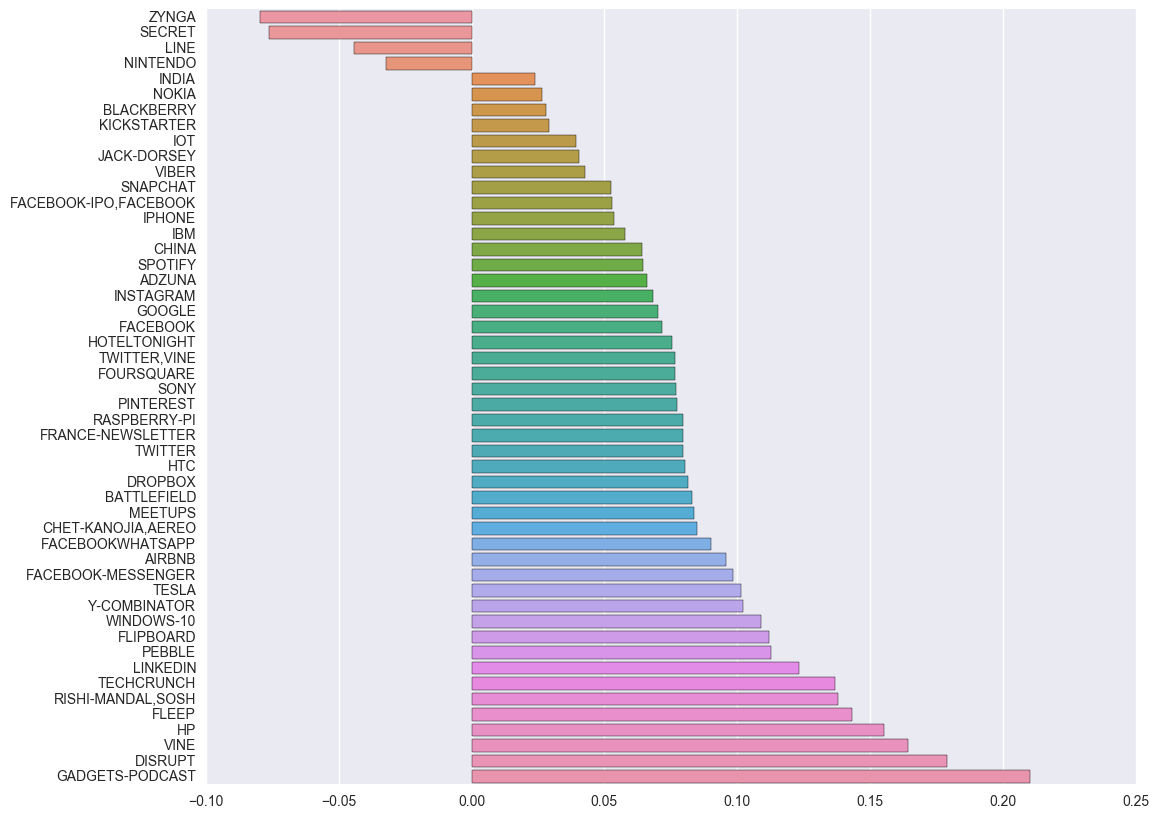

In [96]:
plt.figure(figsize=(12, 10))
sns.barplot(list(zip(*df_sentiment_sorted))[1], [x.upper() for x in list(zip(*df_sentiment_sorted))[0]])
plt.savefig('sentiment.png')

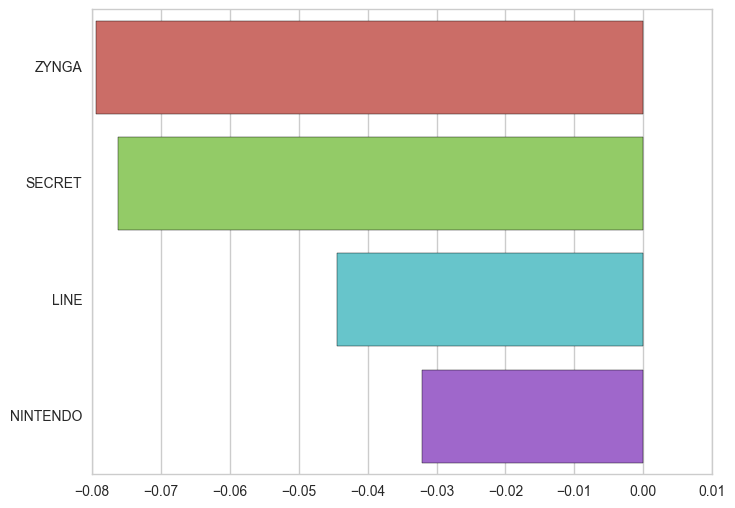

In [132]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(list(zip(*df_sentiment_neg))[1], [x.upper() for x in list(zip(*df_sentiment_neg))[0]], palette = ("hls"))
plt.savefig('sentiment_neg.png', bbox_inches = 'tight')

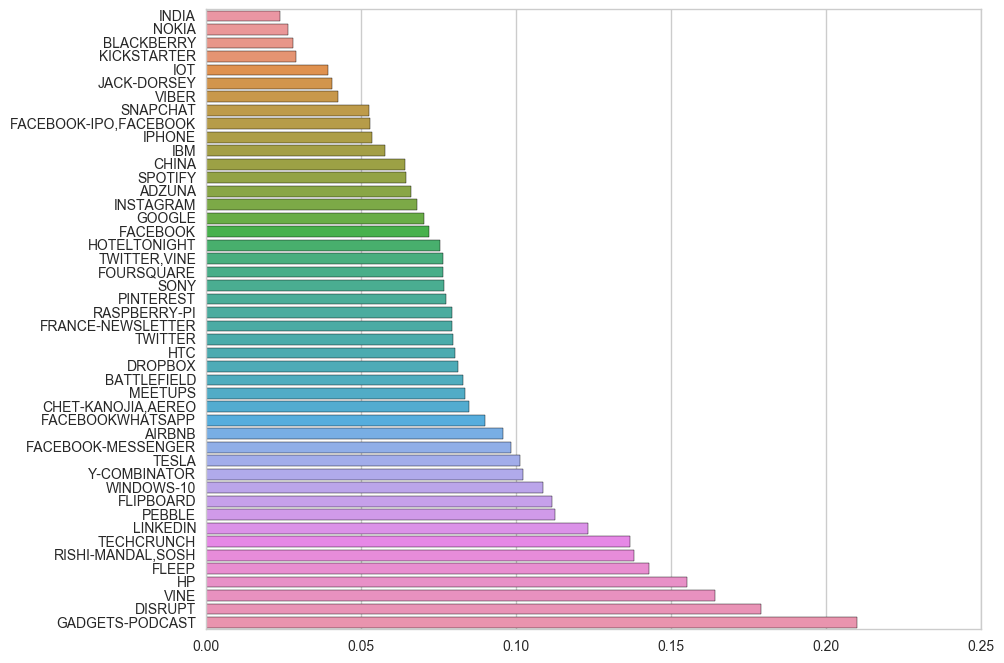

In [131]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(list(zip(*df_sentiment_pos))[1], [x.upper() for x in list(zip(*df_sentiment_pos))[0]])
plt.savefig('sentiment_pos.png', bbox_inches = 'tight')

### Flask Application

In [ ]:
response = requests.post('http://127.0.0.1:5000/rec', json={'rec':'facebook'})

In [ ]:
print (response.json())